# Finding What You Need in PDFs

Finding specific content in PDFs is like being a detective - you need the right tools to hunt down exactly what you're looking for. Natural PDF uses CSS-like selectors to help you find text, lines, images, and other elements in your documents. Think of it like using browser developer tools, but for PDFs.

## Setup

Let's load up a sample PDF to experiment with. This one has various elements we can practice finding.

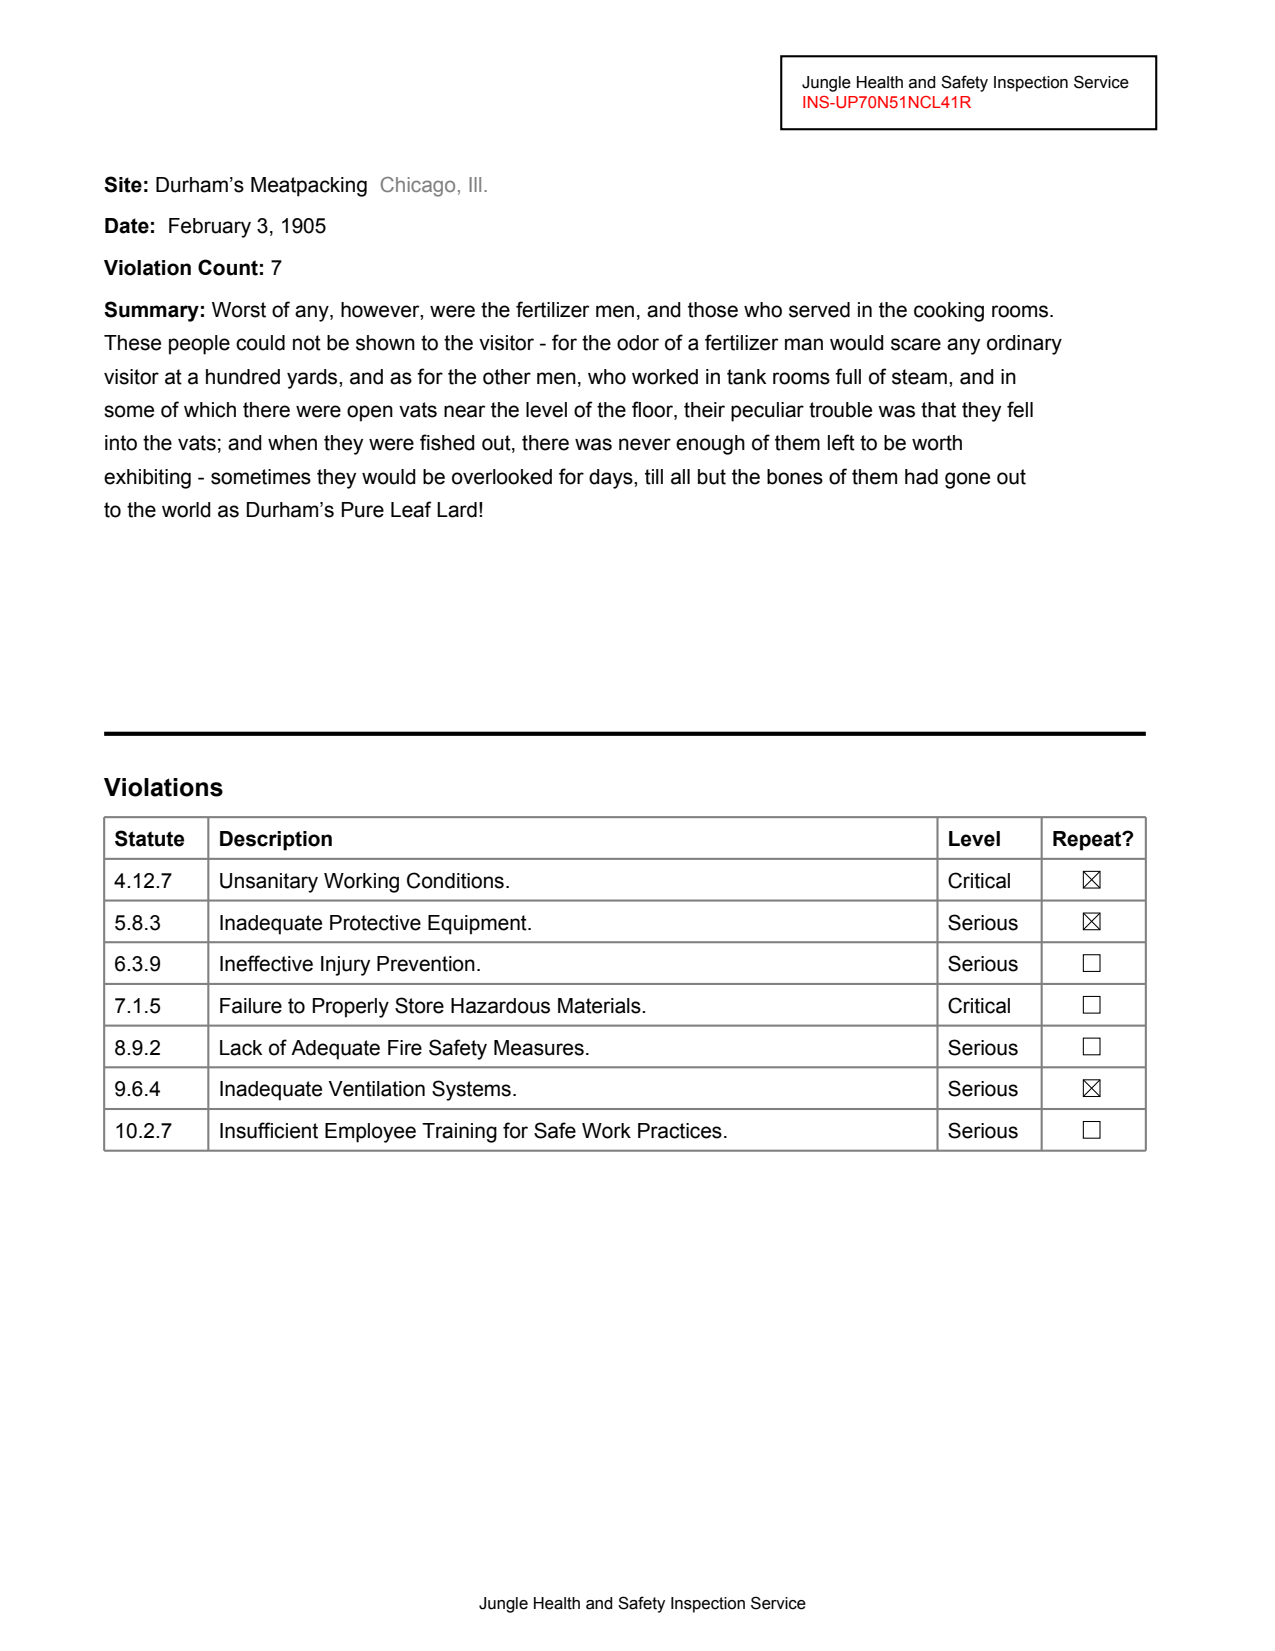

In [1]:
from natural_pdf import PDF

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

# Display the page
page.show()

## The Basics: Finding Elements

You have two main tools: `find()` (gets the first match) and `find_all()` (gets everything that matches). The basic pattern is `element_type[attribute_filter]:pseudo_class`.

### Finding Text by What It Says

In [2]:
# Find the first text element containing "Summary"
summary_text = page.find('text:contains("Summary")')
summary_text

<TextElement text='Summary: ' font='Helvetica' size=10.0, style=['bold'] bbox=(50.0, 144.07000000000005, 101.68, 154.07000000000005)>

In [3]:
# Find all text elements containing "Inadequate"
contains_inadequate = page.find_all('text:contains("Inadequate")')
len(contains_inadequate)

2

In [4]:
# Let's see what we found
with page.highlights() as h:
    h.add(summary_text, color='red', label='Summary')
    h.add(contains_inadequate, color='blue', label='Inadequate')
    h.show()

## Finding Different Types of Elements

PDFs contain more than just text - there are rectangles, lines, images, and other shapes.

In [5]:
# Find all text elements
all_text = page.find_all('text')
len(all_text)

44

In [6]:
# Find all rectangle elements
all_rects = page.find_all('rect')
len(all_rects)

8

In [7]:
# Find all line elements
all_lines = page.find_all('line')
len(all_lines)

21

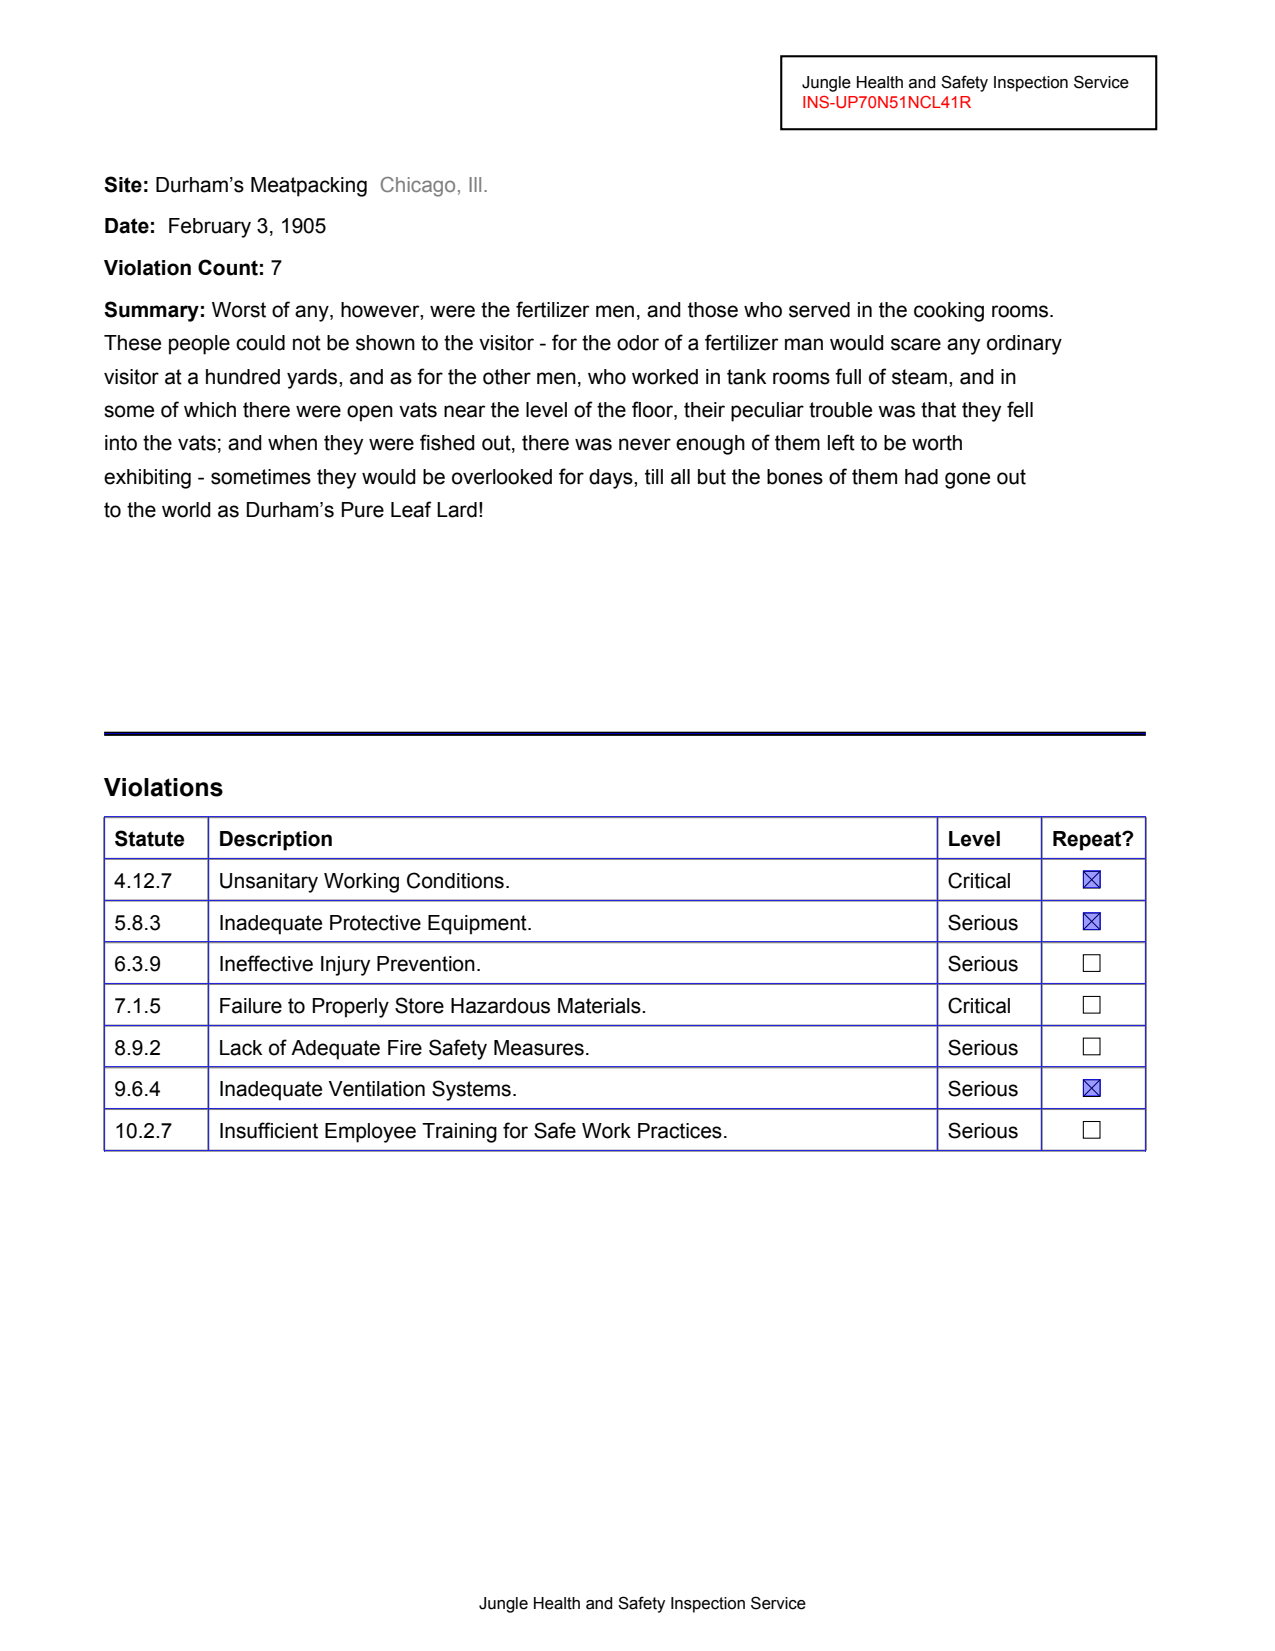

In [8]:
# Show where all the lines are
page.find_all('line').show()

## Filtering by Properties

Use square brackets `[]` to filter elements by their characteristics - size, color, font, etc.

### Common Properties You Can Filter On

| Property      | Example Usage          | What It Does | Notes |
|---------------|------------------------|--------------|-------|
| `size` (text) | `text[size>=12]`       | Font size in points | Use `>`, `<`, `>=`, `<=` |
| `fontname`    | `text[fontname*=Bold]` | Font family name | `*=` means "contains" |
| `color` (text)| `text[color~=red]`     | Text color | `~=` for approximate match |
| `width` (line)| `line[width>1]`        | Line thickness | Useful for finding borders |
| `source`      | `text[source=ocr]`     | Where text came from | `pdf`, `ocr`, or `detected` |
| `type` (region)| `region[type=table]`  | Layout analysis result | From layout detection models |

In [9]:
# Find large text (probably headings)
page.find_all('text[size>=11]')

<ElementCollection[TextElement](count=1)>

In [10]:
# Find text that uses Helvetica font
page.find_all('text[fontname*=Helvetica]')

<ElementCollection[TextElement](count=44)>

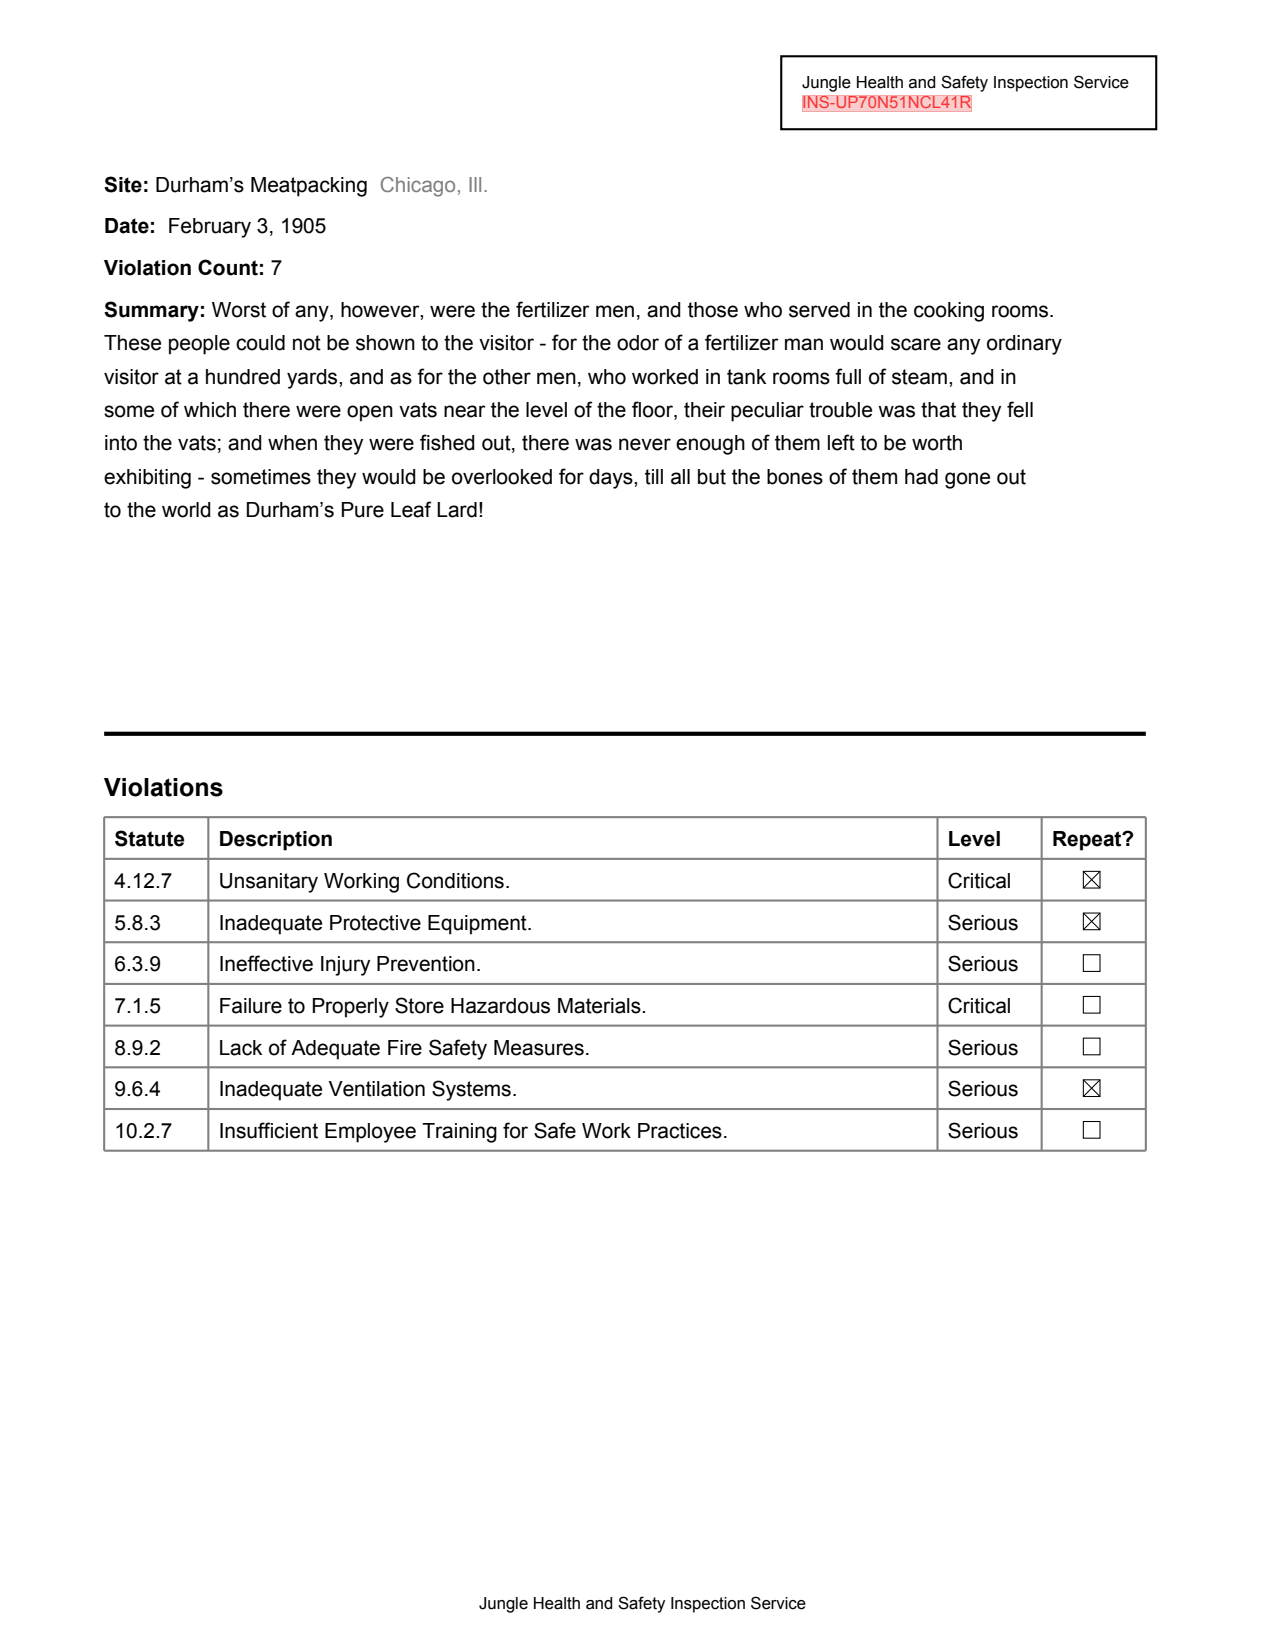

In [11]:
# Find red text in this PDF
red_text = page.find_all('text[color~=red]')
red_text.show()

In [12]:
# Find thick lines (might be important borders)
page.find_all('line[width>=2]')

<ElementCollection[LineElement](count=1)>

## Using Special Conditions (Pseudo-Classes)

These are powerful filters that let you find elements based on their content or relationship to other elements.

### Common Pseudo-Classes

| Pseudo-Class          | Example                           | What It Finds |
|-----------------------|-----------------------------------|---------------|
| `:contains('text')` | `text:contains('Report')`       | Elements containing specific text |
| `:bold`               | `text:bold`                       | Bold text (detected automatically) |
| `:italic`             | `text:italic`                     | Italic text |
| `:strike`             | `text:strike`                     | Struck-through text |
| `:underline`          | `text:underline`                  | Underlined text |
| `:below(selector)`    | `text:below('line[width>=2]')`   | Elements below another element |
| `:above(selector)`    | `text:above('text:contains("Summary")')`| Elements above another element |
| `:near(selector)`     | `text:near('image')`             | Elements close to another element |

*Spatial pseudo-classes like `:below` and `:above` work based on the **first** element that matches the inner selector.*

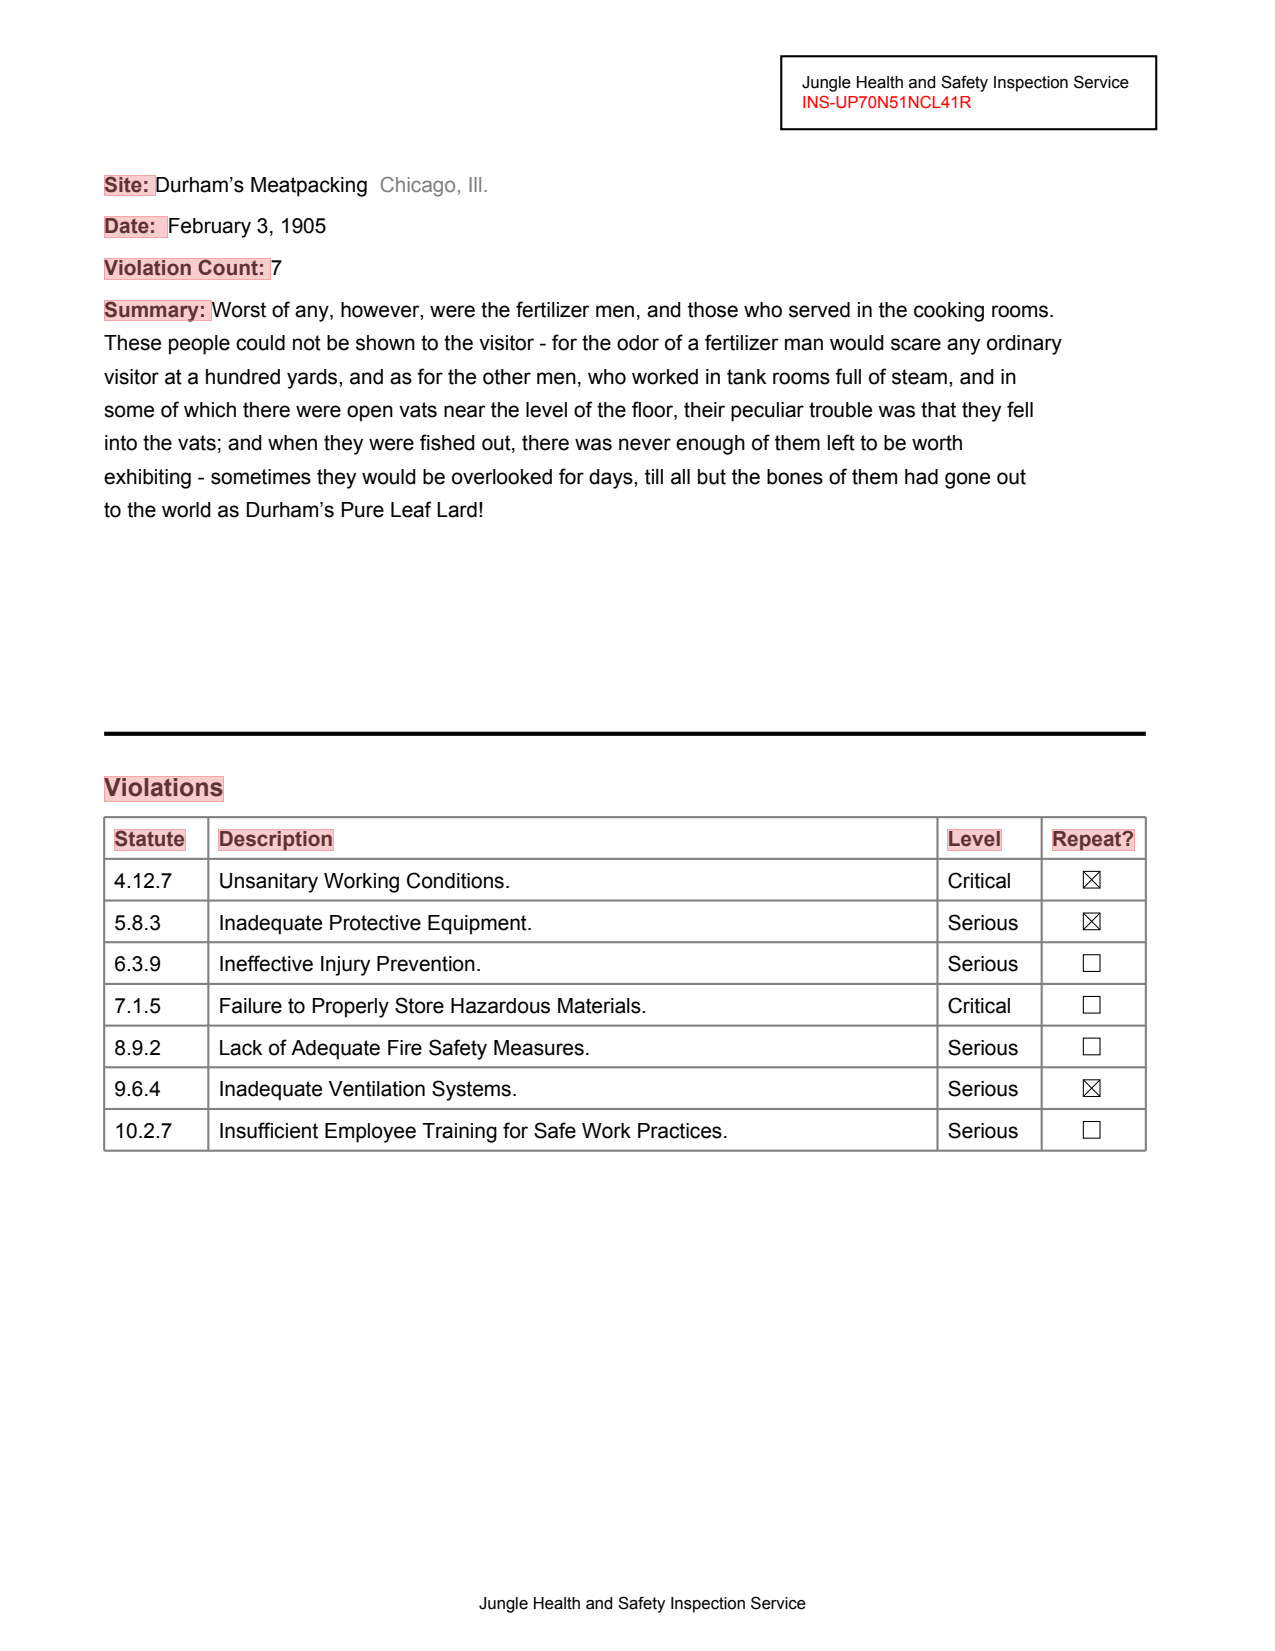

In [13]:
# Find bold text (probably important)
page.find_all('text:bold').show()

In [14]:
# Combine filters: large bold text (definitely headings)
page.find_all('text[size>=11]:bold')

<ElementCollection[TextElement](count=1)>

### Excluding Things with `:not()`

Sometimes it's easier to say what you don't want than what you do want.

In [15]:
# Find all text that's NOT bold
non_bold_text = page.find_all('text:not(:bold)')

# Find all elements that are NOT tables  
not_tables = page.find_all(':not(region[type=table])')

# Find text that doesn't contain "Total"
relevant_text = page.find_all('text:not(:contains("Total"))', case=False)

# Find text that isn't empty
non_empty_text = page.find_all('text:not(:empty)')

### Finding Things Relative to Other Things

This is super useful when you know the structure of your document.

In [16]:
# First, find a thick horizontal line
ref_line = page.find('line[width>=2]')

# Now find text that's above that line
text_above_line = page.find_all('text:above("line[width>=2]")')
text_above_line

<ElementCollection[TextElement](count=17)>

## Advanced Text Searching

When you need more control over how text matching works:

In [17]:
# Case-insensitive search
page.find_all('text:contains("summary")', case=False)

<ElementCollection[TextElement](count=1)>

In [18]:
# Regular expression search (for patterns like inspection IDs)
page.find_all('text:contains("INS-\\w+")', regex=True)

<ElementCollection[TextElement](count=1)>

In [19]:
# Combine regex with case-insensitivity
page.find_all('text:contains("jungle health")', regex=True, case=False)

<ElementCollection[TextElement](count=2)>

## Working with Groups of Elements

`find_all()` returns an `ElementCollection` - like a list, but with PDF-specific superpowers.

In [20]:
# Get all headings (large, bold text)
headings = page.find_all('text[size>=11]:bold')
headings

<ElementCollection[TextElement](count=1)>

In [21]:
# Get the first and last heading in reading order
first = headings.first
last = headings.last
(first, last)

(<TextElement text='Violations' font='Helvetica' size=12.0, style=['bold', 'strike'] bbox=(50.0, 372.484, 107.348, 384.484)>,
 <TextElement text='Violations' font='Helvetica' size=12.0, style=['bold', 'strike'] bbox=(50.0, 372.484, 107.348, 384.484)>)

In [22]:
# Get the physically highest/lowest element
highest = headings.highest()
lowest = headings.lowest()
(highest, lowest)

(<TextElement text='Violations' font='Helvetica' size=12.0, style=['bold', 'strike'] bbox=(50.0, 372.484, 107.348, 384.484)>,
 <TextElement text='Violations' font='Helvetica' size=12.0, style=['bold', 'strike'] bbox=(50.0, 372.484, 107.348, 384.484)>)

In [23]:
# Filter the collection further
service_headings = headings.filter(lambda heading: 'Service' in heading.extract_text())

In [24]:
# Extract text from all elements at once
headings.extract_text()

'Violations'

*Note: `.highest()`, `.lowest()`, etc. will complain if your collection spans multiple pages.*

## Dealing with Weird Font Names

PDFs sometimes have bizarre font names that don't look like normal fonts. Don't worry - they're usually normal fonts with weird internal names.

In [25]:
# Find text with specific font variants (if they exist)
page.find_all('text[font-variant=AAAAAB]')

<ElementCollection[Mixed](count=0)>

## Testing Relationships Between Elements

Want to see how elements relate to each other spatially? Let's try a different PDF:

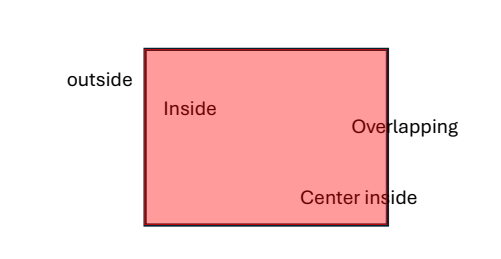

In [26]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/geometry.pdf")
page = pdf.pages[0]

rect = page.find('rect')
rect.show(width=500)